<pre style="text-align: right; width: 100%; font-size: 0.75em; line-height: 0.75em;">
+ ------------------------- + <br>
| 20/04/2025                | <br>
| Héctor Tablero Díaz       | <br>
| Álvaro Martínez Gamo      | <br>
+ ------------------------- + 
</pre>

# **Diffusers**

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./..')

import os

import torch
from torch import Tensor
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

from image_gen import GenerativeModel
from image_gen.samplers import EulerMaruyama
from image_gen.diffusion import VarianceExploding, VariancePreserving, SubVariancePreserving, BaseDiffusion
from image_gen.noise import LinearNoiseSchedule

from typing import Tuple

import matplotlib.pyplot as plt
from IPython.display import HTML
from image_gen.visualization import display_images, create_evolution_widget

c:\Users\alva0\Desktop\3º ICID\2º cuatri\AAUTO3\proyecto\image-gen\examples\..\image_gen\samplers\euler_maruyama.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


The diffusers determine the way that noise is applied. The default classes are `VarianceExploding`, `VariancePreserving` and `SubVariancePreserving`, with the last 2 being Ornstein-Uhlenbeck processes.

### **Differences Between Diffusers**

We can see the outputs of the different models and compare with each other.

The first step is to get the dataset and define the global variables:

In [2]:
# Set up the common variables
epochs = 50
digit = 3

seed = 42

In [3]:
# Load the dataset
data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

# Select a subset to speed up the training process
indices_digit = torch.where(data.targets == digit)[0]
data = Subset(data, indices_digit)

For convenience, we will create a function that includes initializing the model, training and generation:

In [4]:
def diffusion_demo(diffusion_type, num_samples=16, **kwargs):
    """
    Demonstrates the diffusion process for a given diffusion type.
    """
    DIFFUSION_CODES = {
        VarianceExploding: "ve",
        VariancePreserving: "vp-lin",
        SubVariancePreserving: "svp-lin"
    }

    model = GenerativeModel(diffusion=diffusion_type, noise_schedule=LinearNoiseSchedule, sampler=EulerMaruyama)
    
    filename = f'saved_models/mnist_{digit}_{DIFFUSION_CODES[model.diffusion.__class__]}_euler_{epochs}e.pth'

    if os.path.isfile(filename):
        model.load(filename)
    else:
        model.train(data, epochs=epochs)
        # Tip: Save the models for them to be accessible through the dashboard
        model.save(filename)

    samples = model.generate(num_samples, **kwargs)
    display_images(samples)

In [5]:
# diffusion_demo(VarianceExploding, num_samples=16, seed=seed)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/192 [00:00<?, ?it/s]

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

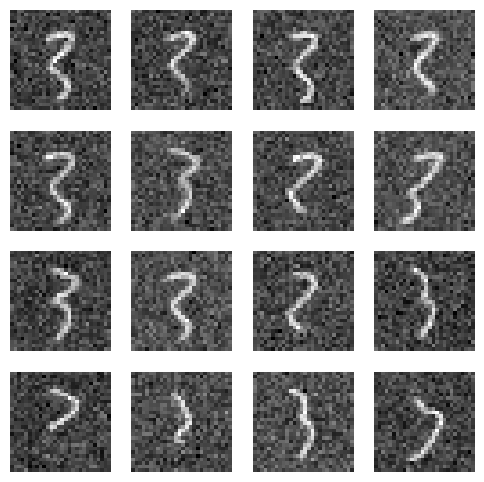

In [5]:
diffusion_demo(VariancePreserving, num_samples=16, seed=seed)

In [7]:
diffusion_demo(SubVariancePreserving, num_samples=16, seed=seed)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

KeyboardInterrupt: 

As it can be seen from these examples, `VarianceExploding` is the fastest to train, followed by `VariancePreserving` and lastly `SubVariancePreserving`, which requires a lot more epochs to produce good results.

### **Creating Custom Classes**

Custom diffusers can be created by inheriting from `BaseDiffusion`. The methods that must be implemented are `forward_sde` and `forward_process`.

It is currently not supported to load models with a custom diffuser, but it is highly recommended that they implement a `config` method for future updates.

In [ ]:
class CustomDiffuser(BaseDiffusion):
    def forward_sde(self, x: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        ...

    def forward_process(self, x0: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        ...